In [1]:
import torch
from d2l import torch as d2l

torch.set_printoptions(2) #精简打印精度

In [12]:
def multibox_prior(data, sizes, ratios):
    '''生成以每个像素为中心具有不同形状的锚框'''
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 将锚点移动到像素的中心，需要设置偏移量
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    # 生成锚框的所有中心点, 使用meshgrid之后再reshape(-1)可以生成两个向量，同样位置的元素可以形成坐标（所有生成的锚点）
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成‘boxes_per_pixel'个高和宽
    # 之后用于创建锚框的四角坐标(xmin, xmax, ymin, ymax)
    # 艹看不懂这儿啥意思
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:])))\
        * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 除以2获得半高和半宽m看不懂
    anchor_manupulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2    
    
    # 每个中心点都有'boxes_per_pixel'个锚框
    # 所以生成含所有锚框中心的网络，重复了'boxes_per_pixel'次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manupulations
    return output.unsqueeze(0)


In [13]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [14]:
# 以(250,250)为中心的第一个锚框
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [17]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    '''显示所有边界框'''
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b','g','r','m','c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
            ha='center', fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

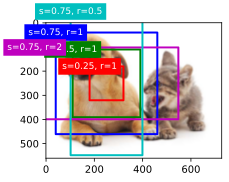

In [18]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, [
's=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'
])